In [1]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

from clusterless import data_preprocess
from clusterless import viz_tools
from clusterless import init_gmm
from clusterless import split_merge
from clusterless import smooth_signals
from clusterless import decode_static

In [2]:
rootpath = "data"
sub_id = "dy016"
samp_freq = 30_000

In [3]:
# load behavior data
behave_dict, behave_idx_dict = data_preprocess.load_behaviors_data(rootpath, sub_id)

# preprocess behavior data
choices, stimuli, transformed_stimuli, one_hot_stimuli, rewards, priors = data_preprocess.preprocess_static_behaviors(behave_dict)
static_behaviors = {'choice': choices, 'stimulus': one_hot_stimuli}

choices left: 0.769, right: 0.231
stimuli left: 0.507, right: 0.493
reward wrong: 0.231, correct: 0.769


all

In [4]:
# load sorted data
ks_spikes_times, ks_spikes_clusters, ks_spikes_amps, ks_spikes_depths, sorted, ks_trials = \
    data_preprocess.load_kilosort_sorted_data(rootpath, sub_id, keep_active_trials=False, samp_freq=samp_freq)

# load kilosort units that passed ibl's quality metrics
good_ks_spikes_indices = data_preprocess.load_kilosort_good_ibl_units(rootpath, sub_id, roi='all', keep_active_trials = False, samp_freq=30_000)

In [5]:
# load unsorted data
spikes_indices, spikes_features, np1_channel_map, stimulus_onset_times, unsorted, trials = \
    data_preprocess.load_unsorted_data(rootpath, sub_id, roi='all', keep_active_trials=False, samp_freq=samp_freq)

# load clusterless model
trials_ids = np.arange(len(trials))
spikes_times = np.vstack([trials[i] for i in trials_ids])[:,0]
structured_unsorted = np.vstack([trials[i] for i in trials_ids])[:,1:] # follows time order

# load gmm after split-merge
gmm = split_merge.merge_gaussians('.', sub_id, structured_unsorted, post_split_gmm=None, post_split_labels=None, merge_ids=None, fit_model=False)
labels = gmm.predict(structured_unsorted)
probs = gmm.predict_proba(structured_unsorted)

In [6]:
# prepare time binned neural activity for decoding
n_projs = 10
neural_data_dict = dict()
tpca_recon_dict = dict()

sorted_neural_data = data_preprocess.compute_time_binned_neural_activity((ks_spikes_times, ks_spikes_clusters), 'sorted', stimulus_onset_times, regional=False)
sorted_tpca_proj, sorted_tpca_recon = smooth_signals.tpca(sorted_neural_data, n_projs=n_projs)
neural_data_dict.update({'sorted': sorted_neural_data})
tpca_recon_dict.update({'sorted': sorted_tpca_recon})

good_ks_neural_data = data_preprocess.compute_time_binned_neural_activity(good_ks_spikes_indices, 'good units', stimulus_onset_times, regional=False)
good_ks_tpca_proj, good_ks_tpca_recon = smooth_signals.tpca(good_ks_neural_data, n_projs=n_projs)
neural_data_dict.update({'good units': good_ks_neural_data})
tpca_recon_dict.update({'good units': good_ks_tpca_recon})

unsorted_neural_data = data_preprocess.compute_time_binned_neural_activity(spikes_indices, 'unsorted', stimulus_onset_times, regional=False)
unsorted_tpca_proj, unsorted_tpca_recon = smooth_signals.tpca(unsorted_neural_data, n_projs=n_projs)
neural_data_dict.update({'unsorted': unsorted_neural_data})
tpca_recon_dict.update({'unsorted': unsorted_tpca_recon})

clusterless_neural_data = data_preprocess.\
    compute_time_binned_neural_activity((spikes_times, labels, probs), 
                                            'clusterless', stimulus_onset_times, regional=False)
clusterless_tpca_proj, clusterless_tpca_recon = smooth_signals.tpca(clusterless_neural_data, n_projs=n_projs)
neural_data_dict.update({'clusterless': clusterless_neural_data})
tpca_recon_dict.update({'clusterless': clusterless_tpca_recon})

In [7]:
# decode using original neural activity
all_decode_results = {'choice': dict(), 'stimulus': dict()}

for behave_type in all_decode_results.keys():
    for data_type in neural_data_dict.keys():
        print(f'{data_type} decoding ...')
        decode_results = decode_static.cv_decode_static(neural_data_dict[data_type], static_behaviors[behave_type], behave_type=behave_type, n_folds=5, seed=seed, shuffle=True)
        all_decode_results[behave_type].update({data_type: decode_results})
np.save(f'{rootpath}/{sub_id}/decode_results/all_decode_results', all_decode_results)

sorted decoding ...
choice fold 1 test accuracy: 0.948 auc: 0.993
choice fold 2 test accuracy: 0.877 auc: 0.946
choice fold 3 test accuracy: 0.912 auc: 0.944
choice fold 4 test accuracy: 0.930 auc: 0.978
choice fold 5 test accuracy: 0.912 auc: 0.853
choice mean of 5-fold cv accuracy: 0.916 auc: 0.943
choice sd of 5-fold cv accuracy: 0.024 auc: 0.049
good units decoding ...
choice fold 1 test accuracy: 0.897 auc: 0.966
choice fold 2 test accuracy: 0.860 auc: 0.942
choice fold 3 test accuracy: 0.947 auc: 0.959
choice fold 4 test accuracy: 0.895 auc: 0.978
choice fold 5 test accuracy: 0.930 auc: 0.874
choice mean of 5-fold cv accuracy: 0.906 auc: 0.944
choice sd of 5-fold cv accuracy: 0.030 auc: 0.037
unsorted decoding ...
choice fold 1 test accuracy: 0.948 auc: 0.978
choice fold 2 test accuracy: 0.860 auc: 0.953
choice fold 3 test accuracy: 0.930 auc: 0.959
choice fold 4 test accuracy: 0.912 auc: 0.984
choice fold 5 test accuracy: 0.895 auc: 0.917
choice mean of 5-fold cv accuracy: 0.909

In [8]:
# decode using smoothed neural activity by tpca
all_tpca_decode_results = {'choice': dict(), 'stimulus': dict()}

for behave_type in all_tpca_decode_results.keys():
    for data_type in tpca_recon_dict.keys():
        print(f'{data_type} decoding ...')
        decode_results = decode_static.cv_decode_static(tpca_recon_dict[data_type], static_behaviors[behave_type], behave_type=behave_type, n_folds=5, seed=seed, shuffle=True)
        all_tpca_decode_results[behave_type].update({data_type: decode_results})
np.save(f'{rootpath}/{sub_id}/decode_results/all_tpca_decode_results', all_tpca_decode_results)

sorted decoding ...
choice fold 1 test accuracy: 0.966 auc: 0.991
choice fold 2 test accuracy: 0.860 auc: 0.962
choice fold 3 test accuracy: 0.947 auc: 0.954
choice fold 4 test accuracy: 0.947 auc: 0.990
choice fold 5 test accuracy: 0.895 auc: 0.849
choice mean of 5-fold cv accuracy: 0.923 auc: 0.949
choice sd of 5-fold cv accuracy: 0.040 auc: 0.052
good units decoding ...
choice fold 1 test accuracy: 0.914 auc: 0.973
choice fold 2 test accuracy: 0.877 auc: 0.954
choice fold 3 test accuracy: 0.947 auc: 0.949
choice fold 4 test accuracy: 0.947 auc: 0.992
choice fold 5 test accuracy: 0.895 auc: 0.809
choice mean of 5-fold cv accuracy: 0.916 auc: 0.935
choice sd of 5-fold cv accuracy: 0.028 auc: 0.065
unsorted decoding ...
choice fold 1 test accuracy: 0.948 auc: 0.985
choice fold 2 test accuracy: 0.842 auc: 0.964
choice fold 3 test accuracy: 0.947 auc: 0.957
choice fold 4 test accuracy: 0.930 auc: 0.994
choice fold 5 test accuracy: 0.877 auc: 0.915
choice mean of 5-fold cv accuracy: 0.909

In [9]:
# load decoding results for plotting
all_decode_results = np.load(f'{rootpath}/{sub_id}/decode_results/all_decode_results.npy', allow_pickle=True).item()
all_tpca_decode_results = np.load(f'{rootpath}/{sub_id}/decode_results/all_tpca_decode_results.npy', allow_pickle=True).item()

regional

In [39]:
rois = ['PO', 'LP', 'DG', 'CA1', 'PPC']
roi = rois[4]

In [40]:
# load sorted data
regional_sorted = data_preprocess.load_kilosort_sorted_data(rootpath, sub_id, roi=roi, keep_active_trials = False, samp_freq=30_000)

# load kilosort units that passed ibl's quality metrics
regional_good_spikes_indices = data_preprocess.load_kilosort_good_ibl_units(rootpath, sub_id, roi=roi, keep_active_trials = False, samp_freq=30_000)

In [41]:
# load unsorted datas
regional_trials = data_preprocess.load_unsorted_data(rootpath, sub_id, roi=roi, keep_active_trials=False, samp_freq=30_000)
regional_spikes_times = np.vstack([regional_trials[i] for i in range(len(regional_trials))])[:,0]
regional_unsorted = np.vstack([regional_trials[i] for i in range(len(regional_trials))])[:,:2]

# load clusterless data
regional_clusterless = np.vstack([regional_trials[i] for i in range(len(regional_trials))])[:,2:]

# load gmm after split-merge
gmm = split_merge.merge_gaussians('.', sub_id, structured_unsorted, post_split_gmm=None, post_split_labels=None, merge_ids=None, fit_model=False)
regional_labels = gmm.predict(regional_clusterless)
regional_probs = gmm.predict_proba(regional_clusterless)

found 15 channels in roi PPC


In [42]:
# prepare time binned neural activity for decoding
n_projs = 10
neural_data_dict = dict()
tpca_recon_dict = dict()

regional_sorted_neural_data = data_preprocess.compute_time_binned_neural_activity(regional_sorted, 'sorted', stimulus_onset_times, regional=True)
regional_sorted_tpca_proj, regional_sorted_tpca_recon = smooth_signals.tpca(regional_sorted_neural_data, n_projs=n_projs)
neural_data_dict.update({'sorted': regional_sorted_neural_data})
tpca_recon_dict.update({'sorted': regional_sorted_tpca_recon})

regional_good_neural_data = data_preprocess.compute_time_binned_neural_activity(regional_good_spikes_indices, 'good units', stimulus_onset_times, regional=True)
regional_good_tpca_proj, regional_good_tpca_recon = smooth_signals.tpca(regional_good_neural_data, n_projs=n_projs)
neural_data_dict.update({'good units': regional_good_neural_data})
tpca_recon_dict.update({'good units': regional_good_tpca_recon})

regional_unsorted_neural_data = data_preprocess.compute_time_binned_neural_activity(regional_unsorted, 'unsorted', stimulus_onset_times, regional=True)
regional_unsorted_tpca_proj, regional_unsorted_tpca_recon = smooth_signals.tpca(regional_unsorted_neural_data, n_projs=n_projs)
neural_data_dict.update({'unsorted': regional_unsorted_neural_data})
tpca_recon_dict.update({'unsorted': regional_unsorted_tpca_recon})

regional_clusterless_neural_data = data_preprocess.\
    compute_time_binned_neural_activity((regional_spikes_times, regional_labels, regional_probs), 
                                            'clusterless', stimulus_onset_times, regional=True)
regional_clusterless_tpca_proj, regional_clusterless_tpca_recon = smooth_signals.tpca(regional_clusterless_neural_data, n_projs=n_projs)
neural_data_dict.update({'clusterless': regional_clusterless_neural_data})
tpca_recon_dict.update({'clusterless': regional_clusterless_tpca_recon})

In [43]:
# decode using original neural activity
regional_decode_results = {'choice': dict(), 'stimulus': dict()}

for behave_type in regional_decode_results.keys():
    for data_type in neural_data_dict.keys():
        print(f'{data_type} decoding ...')
        decode_results = decode_static.cv_decode_static(neural_data_dict[data_type], static_behaviors[behave_type], behave_type=behave_type, n_folds=5, seed=seed, shuffle=True)
        regional_decode_results[behave_type].update({data_type: decode_results})
np.save(f'{rootpath}/{sub_id}/decode_results/{roi.lower()}_decode_results', regional_decode_results)

sorted decoding ...
choice fold 1 test accuracy: 0.776 auc: 0.824
choice fold 2 test accuracy: 0.684 auc: 0.645
choice fold 3 test accuracy: 0.895 auc: 0.732
choice fold 4 test accuracy: 0.719 auc: 0.686
choice fold 5 test accuracy: 0.807 auc: 0.726
choice mean of 5-fold cv accuracy: 0.776 auc: 0.722
choice sd of 5-fold cv accuracy: 0.073 auc: 0.060
good units decoding ...
choice fold 1 test accuracy: 0.776 auc: 0.598
choice fold 2 test accuracy: 0.649 auc: 0.666
choice fold 3 test accuracy: 0.860 auc: 0.597
choice fold 4 test accuracy: 0.737 auc: 0.621
choice fold 5 test accuracy: 0.825 auc: 0.430
choice mean of 5-fold cv accuracy: 0.769 auc: 0.582
choice sd of 5-fold cv accuracy: 0.073 auc: 0.080
unsorted decoding ...
choice fold 1 test accuracy: 0.776 auc: 0.665
choice fold 2 test accuracy: 0.649 auc: 0.522
choice fold 3 test accuracy: 0.860 auc: 0.582
choice fold 4 test accuracy: 0.737 auc: 0.541
choice fold 5 test accuracy: 0.825 auc: 0.709
choice mean of 5-fold cv accuracy: 0.769

In [44]:
# decode using smoothed neural activity by tpca
regional_tpca_decode_results = {'choice': dict(), 'stimulus': dict()}

for behave_type in all_tpca_decode_results.keys():
    for data_type in tpca_recon_dict.keys():
        print(f'{data_type} decoding ...')
        decode_results = decode_static.cv_decode_static(tpca_recon_dict[data_type], static_behaviors[behave_type], behave_type=behave_type, n_folds=5, seed=seed, shuffle=True)
        regional_tpca_decode_results[behave_type].update({data_type: decode_results})
np.save(f'{rootpath}/{sub_id}/decode_results/{roi.lower()}_tpca_decode_results', regional_tpca_decode_results)

sorted decoding ...
choice fold 1 test accuracy: 0.810 auc: 0.838
choice fold 2 test accuracy: 0.702 auc: 0.665
choice fold 3 test accuracy: 0.807 auc: 0.760
choice fold 4 test accuracy: 0.789 auc: 0.768
choice fold 5 test accuracy: 0.842 auc: 0.847
choice mean of 5-fold cv accuracy: 0.790 auc: 0.776
choice sd of 5-fold cv accuracy: 0.047 auc: 0.066
good units decoding ...
choice fold 1 test accuracy: 0.776 auc: 0.581
choice fold 2 test accuracy: 0.649 auc: 0.691
choice fold 3 test accuracy: 0.860 auc: 0.638
choice fold 4 test accuracy: 0.737 auc: 0.690
choice fold 5 test accuracy: 0.825 auc: 0.379
choice mean of 5-fold cv accuracy: 0.769 auc: 0.596
choice sd of 5-fold cv accuracy: 0.073 auc: 0.116
unsorted decoding ...
choice fold 1 test accuracy: 0.776 auc: 0.687
choice fold 2 test accuracy: 0.649 auc: 0.623
choice fold 3 test accuracy: 0.842 auc: 0.610
choice fold 4 test accuracy: 0.649 auc: 0.476
choice fold 5 test accuracy: 0.825 auc: 0.643
choice mean of 5-fold cv accuracy: 0.748

In [45]:
# load decoding results for plotting
regional_decode_results = np.load(f'{rootpath}/{sub_id}/decode_results/{roi.lower()}_decode_results.npy', allow_pickle=True).item()
regional_tpca_decode_results = np.load(f'{rootpath}/{sub_id}/decode_results/{roi.lower()}_tpca_decode_results.npy', allow_pickle=True).item()

plotting

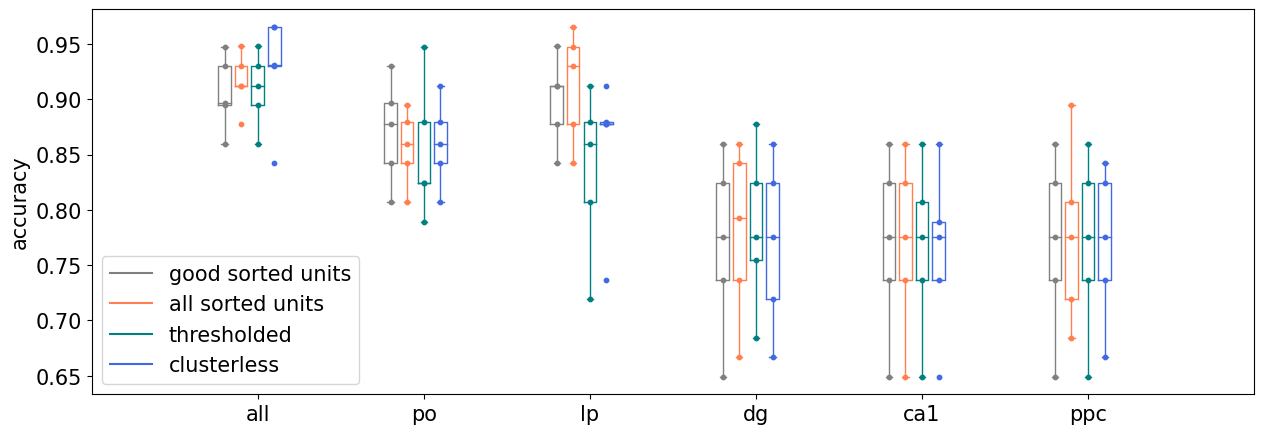

In [5]:
# box plots for choice
viz_tools.plot_compare_decoder_boxplots(rootpath, sub_id, behave_type='choice', metric_type='accuracy', n_folds=5, add_smooth=False, save_fig=True)

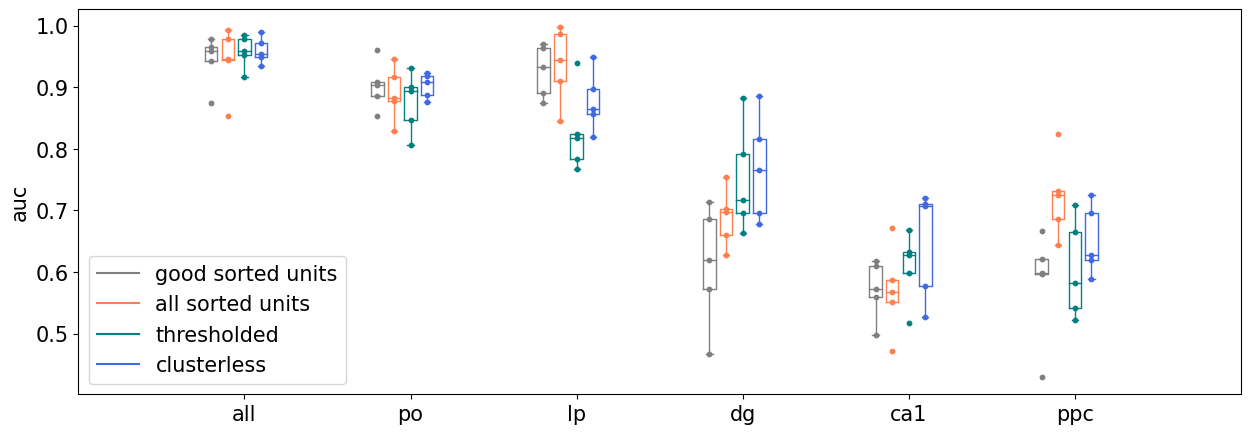

In [4]:
# box plots for choice
viz_tools.plot_compare_decoder_boxplots(rootpath, sub_id, behave_type='choice', metric_type='auc', n_folds=5, add_smooth=False, save_fig=True)

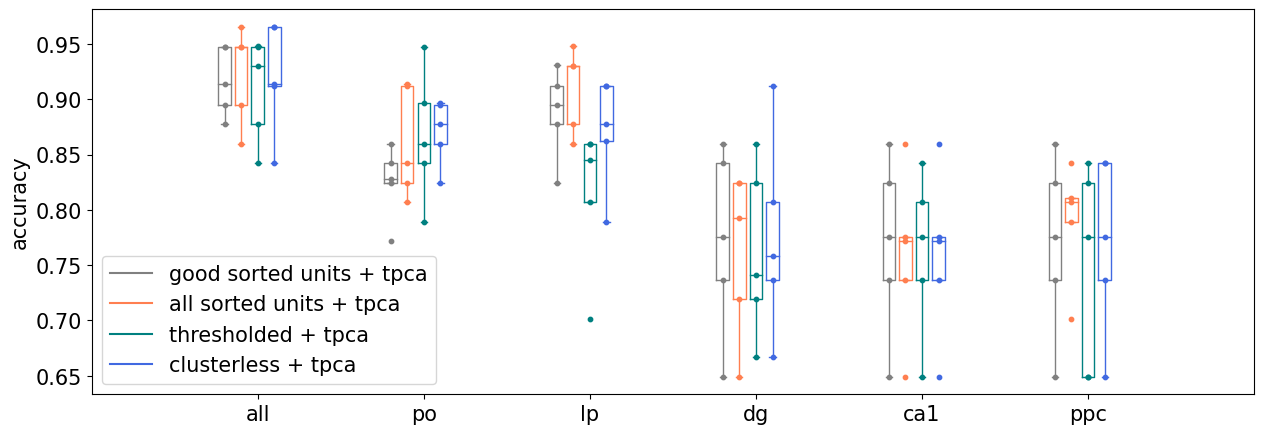

In [3]:
# box plots for choice + tpca
viz_tools.plot_compare_decoder_boxplots(rootpath, sub_id, behave_type='choice', metric_type='accuracy', n_folds=5, add_smooth=True, save_fig=True)

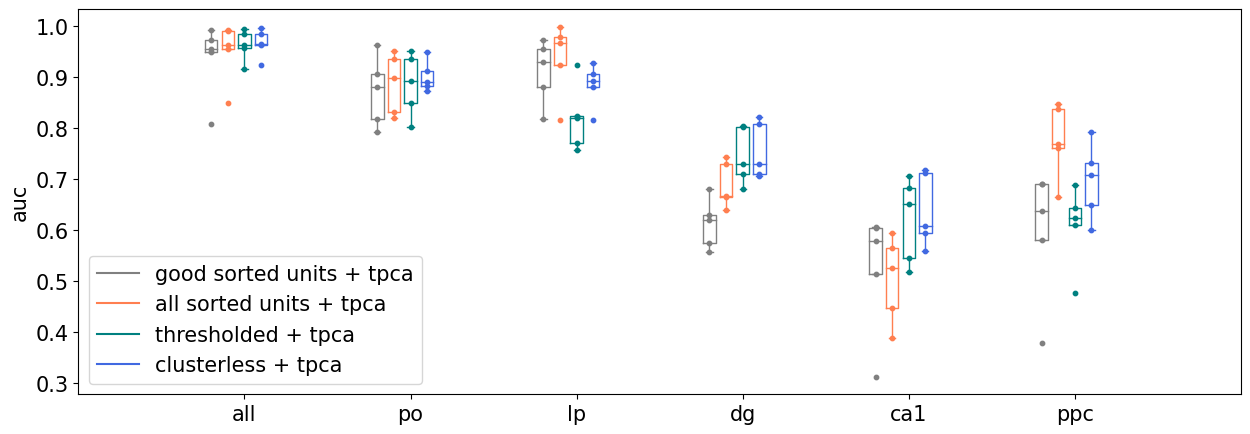

In [6]:
# box plots for choice + tpca
viz_tools.plot_compare_decoder_boxplots(rootpath, sub_id, behave_type='choice', metric_type='auc', n_folds=5, add_smooth=True, save_fig=True)

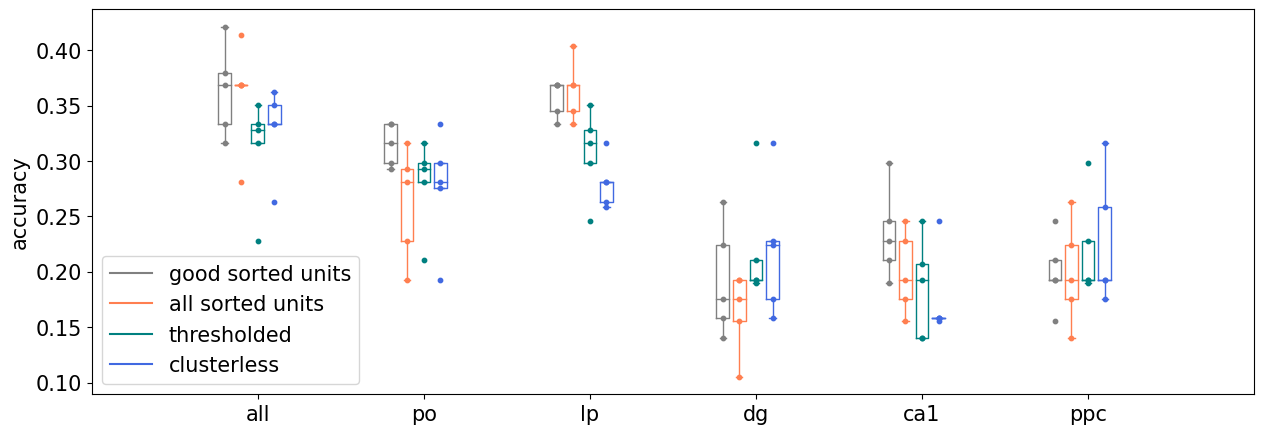

In [7]:
# box plots for stimulus
viz_tools.plot_compare_decoder_boxplots(rootpath, sub_id, behave_type='stimulus', metric_type='accuracy', n_folds=5, add_smooth=False, save_fig=True)

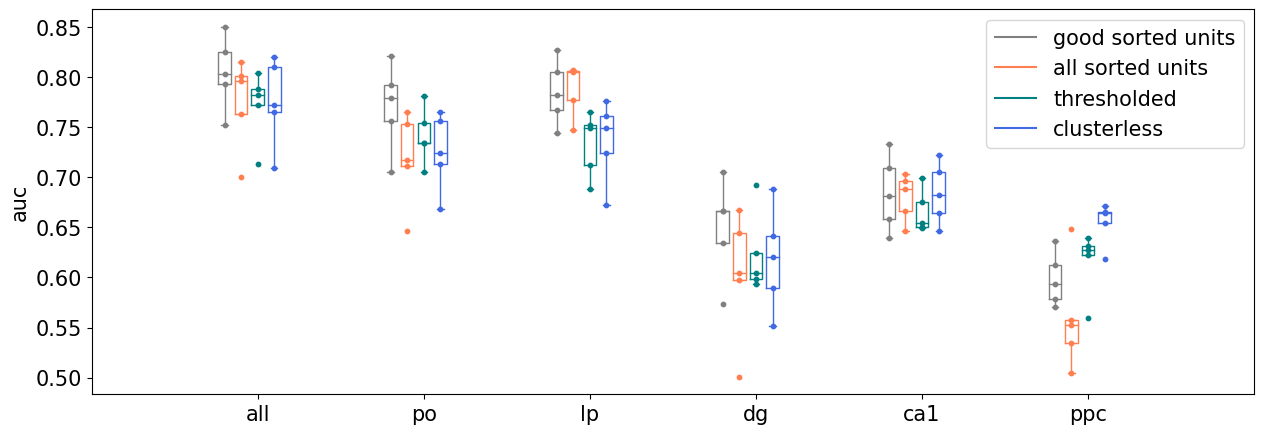

In [8]:
# box plots for choice
viz_tools.plot_compare_decoder_boxplots(rootpath, sub_id, behave_type='stimulus', metric_type='auc', n_folds=5, add_smooth=False, save_fig=True)

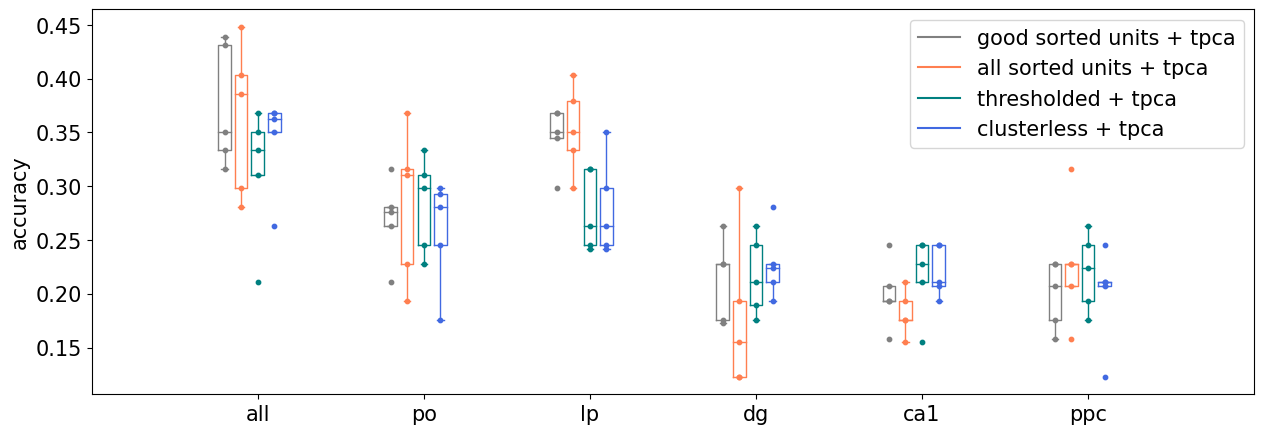

In [9]:
# box plots for choice + tpca
viz_tools.plot_compare_decoder_boxplots(rootpath, sub_id, behave_type='stimulus', metric_type='accuracy', n_folds=5, add_smooth=True, save_fig=True)

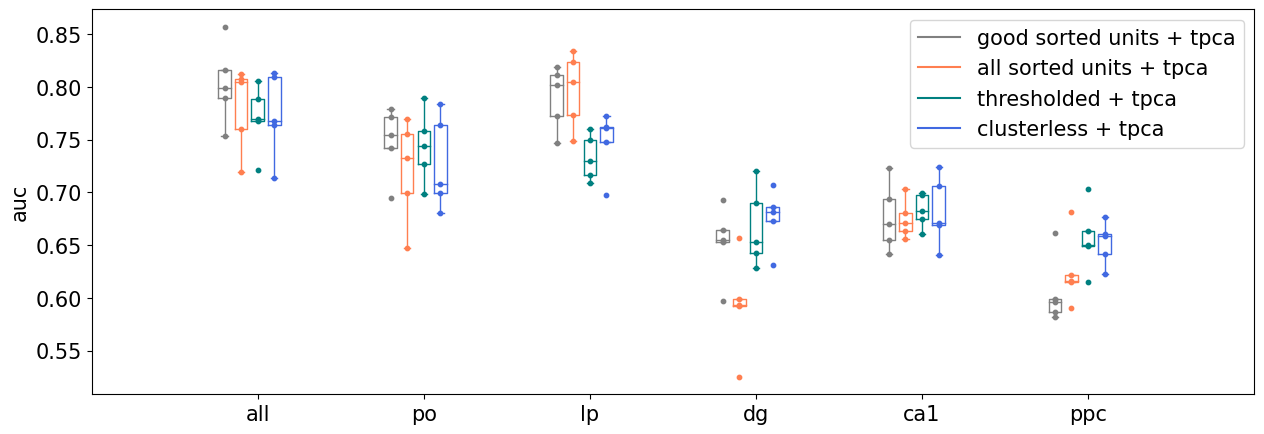

In [10]:
# box plots for choice + tpca
viz_tools.plot_compare_decoder_boxplots(rootpath, sub_id, behave_type='stimulus', metric_type='auc', n_folds=5, add_smooth=True, save_fig=True)

In [ ]:
# visualize stimuli traces


